# Model interpretation (Estimators of the longitudinal frequencies)

The estimators HistGradientBoosting and LightGBM showed the best scores during the benchmark and the cross-validation. In this notebook we will tune their hyperparameters with a Bayesian approach to optimize the precisions.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import seaborn as sns
import shap
import statsmodels.api as sm

## Load variables and target

In the first step we load the dataset again and define the explanatory and target variables again:

In [2]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'
#base_dir = r'D:\FBr\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', str(fam) + '-feat-parameters.ft')
df_params = pd.read_feather(ft_param_path)

In [3]:
lst_param = df_params.columns.to_list()

In [4]:
# Explanatory variables: all slot classes are considered, we add the 4 encoded columns to the selected dataset
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
# Target variable is the frequency of the longitudinal mode
target = 'freq_long'

X = df_params[lst_expl + lst_slot_class]
y = df_params[target]

In [5]:
# New Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

We define a pipeline containing 2 steps: the scaling of the variables and the regressor:

## HistGradientBoosting

In [6]:
# Create the main pipeline
preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

tuned_regressor = HistGradientBoostingRegressor(
                                                l2_regularization=1.0,
                                                learning_rate=0.0903,
                                                loss='gamma',
                                                max_depth=3,
                                                max_iter=1000,
                                                min_samples_leaf=85
                                                )

pipe_tuned_hist = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', tuned_regressor)
                        ])

In [7]:
# Perform the bayesian search
pipe_tuned_hist.fit(X_train, y_train)
print ('Score of the test set:', pipe_tuned_hist.score(X_test, y_test))

Score of the test set: 0.9924209030658435


## Analysis of the residuals

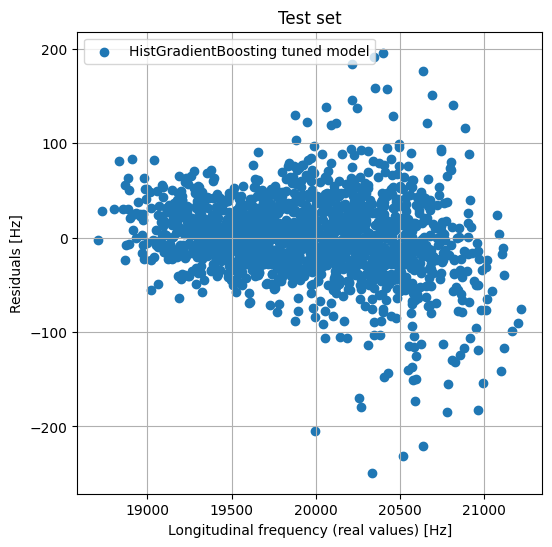

In [8]:
pipe_tuned_hist.fit(X_train, y_train)
y_pred_tuned_hist = pd.Series(pipe_tuned_hist.predict(X_test), index=y_test.index)
residuals_hist = y_pred_tuned_hist-y_test

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, residuals_hist, label='HistGradientBoosting tuned model')
plt.xlabel('Longitudinal frequency (real values) [Hz]')
plt.ylabel('Residuals [Hz]')
plt.title('Test set')
plt.grid(True)
plt.legend()
plt.show()

The Q-Q plot of the residuals checks the normality of the distribution by comparing the distribution of the actual data with a theoretical distribution (hier a standard normal law)

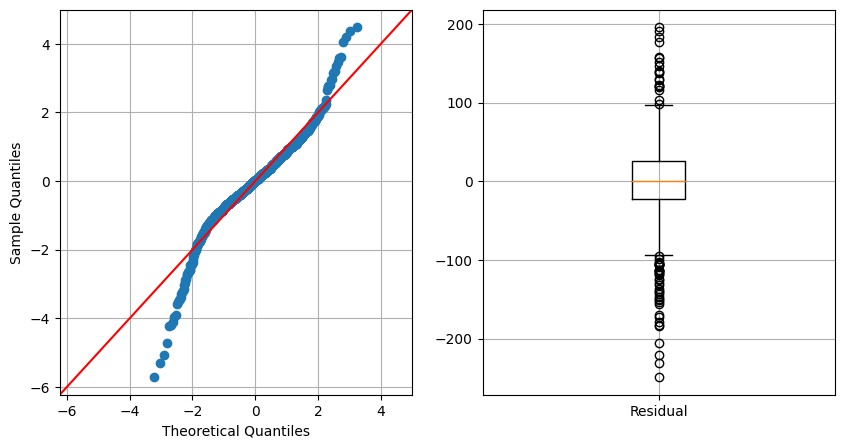

In [19]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
sm.qqplot(residuals_hist, fit=True, line='45', ax=ax)
plt.grid(True)
plt.plot

ax = fig.add_subplot(1, 2, 2)
plt.boxplot(residuals_hist)
plt.xticks([1], ['Residual'], rotation=0)
plt.xticks([1], ['Residual'], rotation=0)
plt.grid(True)

plt.show()

* Except for the outliers, the residuals follow a normal law
* There is no offset between the line and the points (mean of data is 0)
* The max absolute error is about 250 Hz

In [20]:
residuals_hist.describe()

count    1598.000000
mean        0.324387
std        43.641717
min      -249.038442
25%       -22.395594
50%         0.745034
75%        25.286935
max       195.858832
dtype: float64

The model will be interpretated with SHAP, expecially the design points with the best and with the worst predictions

In [22]:
residuals_hist_abs = np.abs(residuals_hist)
idx_res_max = residuals_hist_abs.idxmax()
idx_res_min = residuals_hist_abs.idxmin()
print('Design point with the largest residual:', idx_res_max, 'Error:', residuals_hist_abs.max(), 'Hz')
print('Design point with the smallest residual:', idx_res_min, 'Error:', residuals_hist_abs.min(), 'Hz')

Design point with the largest residual: 7419 Error: 249.0384420348455 Hz
Design point with the smallest residual: 6390 Error: 0.008057316495978739 Hz


## SHAP

In [23]:
# Select 100 instances for use as the background distribution
X100 = shap.utils.sample(X, 100)  

# Add the best and worse design points to the dataset
X102 = pd.concat([X100, X.loc[[idx_res_max]], X.loc[[idx_res_min]]])

In [25]:
explainer = shap.Explainer(pipe_tuned_hist.predict, X102)
shap_values = explainer(X102)

PermutationExplainer explainer: 103it [02:13,  1.36s/it]                         


The SHAP bar plot displays the mean absolute values of the Shapley values over all the observations. It creates a global measure of the feature importances. As alrealy known the length of the sonotrode has the greatest influence on the longitudinal frequency. 

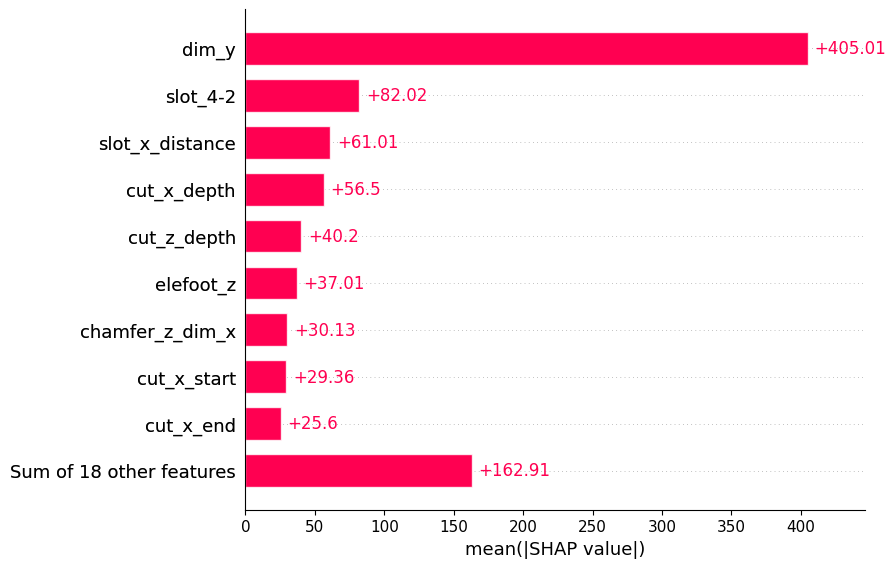

In [31]:
plt.figure(figsize=(4, 4))
shap.plots.bar(shap_values)

The beeswarm plot provides a visual summary of feature importance across multiple predictions. The vertical spread of the swarm at each feature represents the density of data points:
* As the length (dim_y) value increases its SHAP value decreases (as expected)
* The second most important feature is the slot distribution class "4-2", the values are 0 or 1. If the class is active, the frequency is about 200 Hz lower. This effect can be explained that mass is removed near the nodal plance, which lower the longitudinal frequency
* The chamfer widths and cut depths increase the frequencies since mass is removed at points with great displacements

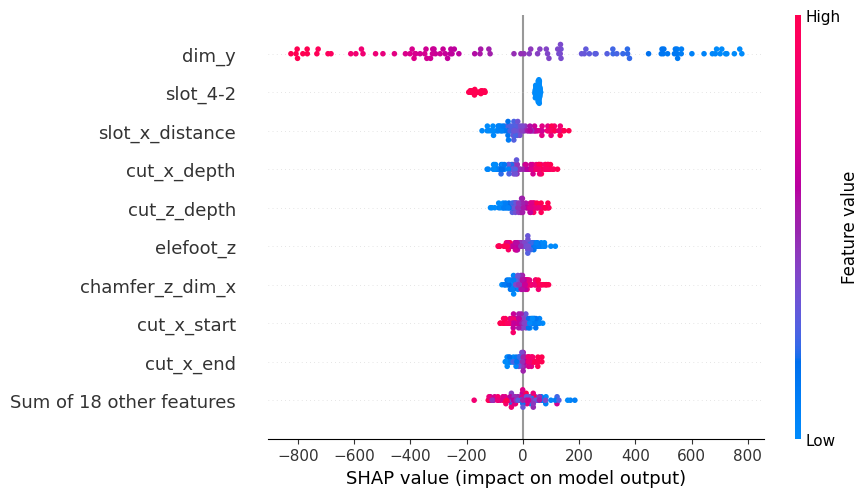

In [30]:
plt.figure(figsize=(4, 4))
shap.plots.beeswarm(shap_values)

The waterfall plot display how th SHAP values of each feature move the model output to the final model prediction:
* The first plot display the worst prediction (although the longitudinal frequency is near to the expected value of the model output of 20030 Hz)
* The second plt display the best prediction

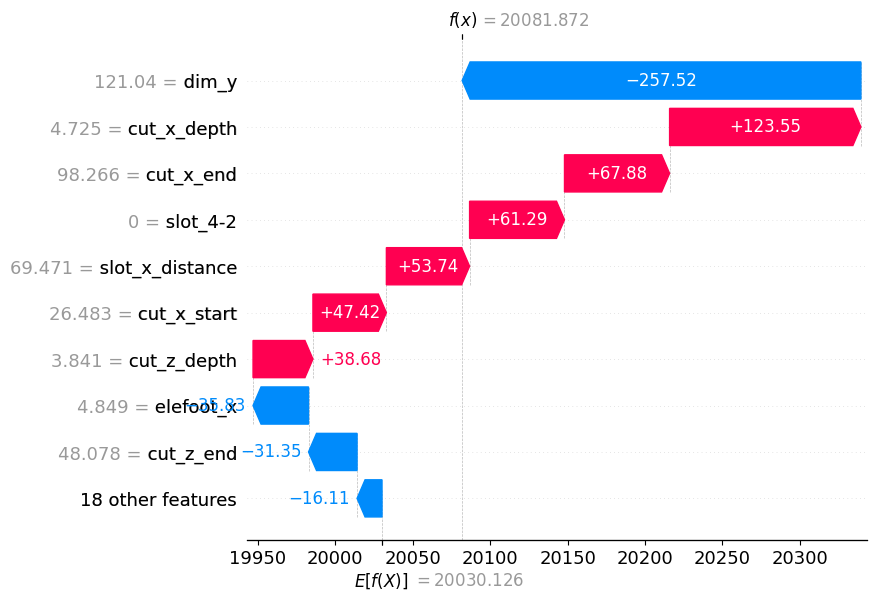

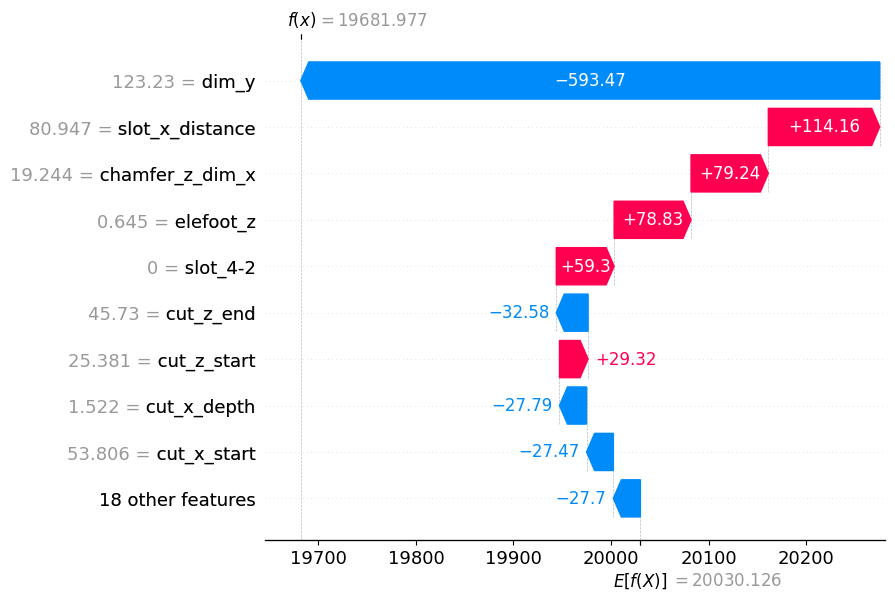

In [37]:
# Design point with the greatest residual
shap.plots.waterfall(shap_values[-2])
# Design point with the greatest residual
shap.plots.waterfall(shap_values[-1])